<a href="https://colab.research.google.com/github/jordi1215/quantum-walk-visualization/blob/main/quantum_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our project is an implementation of a *quantum walk*.

**What is a quantum walk?**

A quantum walk is an implementation of a *random walk* using *quantum computing*.

This leads to the question... **What is a random walk?**

A random walk is a traversal of a *Markov chain*. A Markov chain is a graph with directed, weighted edges. The weights of the edges represent the probability of that edge being traversed. All the weights of the outgoing edges from a node have to add up to *1*, since it's a probability.

A little confusing? Here's an example.


![](https://drive.google.com/uc?export=view&id=1-CCHJuHc0n74Z4DU8uemPktWFbv-JLIu)

**Why are random walks useful?**

Random walks are used to model many processes in Chemistry, Physics and Biology. For example, they can give us a good understanding of the statistical processes involved in genetic drift, and they describe an ideal chain in polymer physics. They are also important in finance, psychology, ecology and computer science.

Source: Statistics How-To

In [ ]:
# install necessary dependencies
!pip install retworkx
!pip install pydot pillow
!pip install qiskit
!apt install graphviz
!pip install pylatexenc

import retworkx
from retworkx.visualization import graphviz_draw, mpl_draw
import pylatexenc
import matplotlib.pyplot as plt
from qiskit import *
import numpy as np
import networkx as nx
import numpy.linalg as la
from scipy.linalg import expm
from qiskit.extensions import HamiltonianGate
from qiskit.visualization import plot_histogram
import imageio

In [ ]:
def pad_zeros(adjacency):
    '''
    Helper function for padding zeros to increase adjacency
    matrix of shape (n,n) to (2**n, 2**n).

    Parameters: adjacency (ndarray): adjacency of graph
    Returns: full_matrix (ndarray): new adjacency with padded zeroes
    '''
    full_matrix = np.zeros((2 ** len(adjacency), 2 ** len(adjacency)))
    for i in range(len(adjacency)):
        for j in range(len(adjacency)):
            if adjacency[i][j] != 0:
                full_matrix[2 ** i][2 ** j] = adjacency[i][j]
    return full_matrix

In the following block of code, we construct a simple path on two vertices and path on three vertices. We also show the function of the pad_zeros function, increasing the dimensionality of the adjacencies to fit our needs.

In [ ]:
# construct path on 2 and three vertices and get adjacency
P2 = nx.path_graph(2)
P3 = nx.path_graph(3)
adj_P2 = nx.adjacency_matrix(P2).toarray()
adj_P3 = nx.adjacency_matrix(P3).toarray()

# pad adjacency with zeroes to increase dimensionality
full_mat_P2 = pad_zeros(adj_P2)
full_mat_P3 = pad_zeros(adj_P3)

We can use the adjacency matrix ($A$) as the Hamiltonian operator ($H$) of the quantum system, satisfying the Schrodinger equation $i \hbar \dot{\psi}=H\psi$. The adjacency matrices are Hermitian, and so $e^{-iAt}$ (the solution to this equation) is a unitary matrix. We can use this matrix exponential as the evolution operator on our quantum system of qubits. These are constructed using qiskit's HamiltonianGate object.

In [ ]:
# construct HamiltonianGate from padded adjacencies
ExpGateP2 = HamiltonianGate(full_mat_P2, np.pi/2)
ExpGateP3 = HamiltonianGate(full_mat_P3, np.pi/2)

We can now use these gates in a quantum circuit to simulate a quantum walk. We put the state of the system in $|01>$ and evolve it over a time interval of $\frac{\pi}{2}$. We can measure each qubit to get the final state of the system. 

In [ ]:
# construct quantum circuit for path on two vertices
qr_P2 = QuantumRegister(2, 'q')
cr_P2 = ClassicalRegister(2)
circ_P2 = QuantumCircuit(qr_P2, cr_P2)

# initialize in state |100> and add measurements
circ_P2.x(0)
circ_P2.append(ExpGateP2, qr_P2)
for i in range(len(qr_P2)):
    circ_P2.measure(qr_P2[i], cr_P2[i])

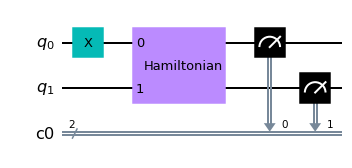

In [ ]:
# visualize quantum circuit
circ_P2.draw(output='mpl')

We know from the mathematical literature on quantum walks that a path on two vertices exhibits "perfect state transfer" (PST) at time $\frac{\pi}{2}$, and so the result of this circuit should always yield $|10>$ if it starts in the state $|01>$ and vice-versa. Below, we show that the resulting counts reflect this property of the graph.

In [ ]:
# simulate circuit from path on two vertices
job = execute(circ_P2, backend=BasicAer.get_backend('qasm_simulator'))
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]
print("Resulting Counts:", counts)

Resulting Counts: [{'10': 1024}]


We repeat a similar process as above for the path on three vertices.

In [ ]:
# construct quantum circuit for path on three vertices
qr_P3 = QuantumRegister(3, 'q')
cr_P3 = ClassicalRegister(3)
circ_P3 = QuantumCircuit(qr_P3, cr_P3)

# initialize in state |100> and add measurements
circ_P3.x(0)
circ_P3.append(ExpGateP3, qr_P3)
for i in range(len(qr_P3)):
    circ_P3.measure(qr_P3[i], cr_P3[i])

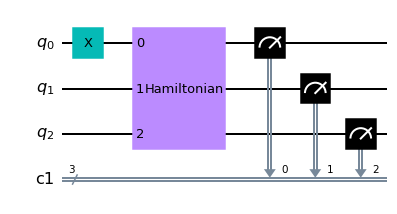

In [ ]:
# visualize quantum circuit
circ_P3.draw(output='mpl')

Since the path on three vertices does not have PST at time $\frac{\pi}{2}$, we see that the resulting counts are distributed unevenly between the three different vertices. We also display these results in a histogram.

Resulting Counts: [{'100': 678, '010': 305, '001': 41}]


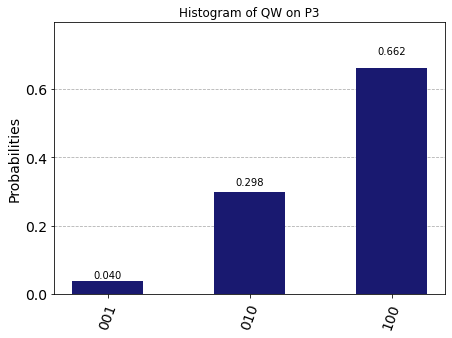

In [ ]:
# simulate circuit from path on two vertices
job = execute(circ_P3, backend=BasicAer.get_backend('qasm_simulator'))
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]
print("Resulting Counts:", counts)
plot_histogram(job.result().get_counts(), color='midnightblue', title="Histogram of QW on P3")

Below we illustrate a different approach for representing a graph as qubits. While each qubit above corresponded to a node on the graph, we can instead represent more nodes on the graph by having each bitstring correspond to a different node. The quantum walk in both approaches works out the same mathematically and can thus be visualized similarly.

In [ ]:
# construct random 8x8 matrix (3 qubits)
random_matrix = np.zeros((8,8))
for i in range(0,len(random_matrix)-1):
    for j in range(i+1,len(random_matrix)-1):
        random_matrix[i][j] = np.random.randint(2)
        random_matrix[j][i] = random_matrix[i][j]

# use random matrix as HamiltonianGate
ExpGateRandom = HamiltonianGate(random_matrix, np.pi/3)

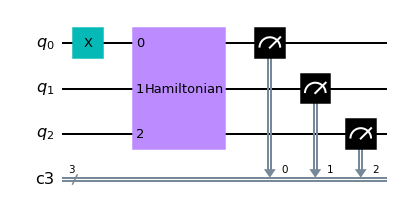

In [ ]:
# construct quantum circuit for random eight vertex graph
qr_random = QuantumRegister(3, 'q')
cr_random = ClassicalRegister(3)
circ_random = QuantumCircuit(qr_random, cr_random)

# initialize in state |100> and add measurements
circ_random.x(0)
circ_random.append(ExpGateRandom, qr_random)
for i in range(len(qr_random)):
    circ_random.measure(qr_random[i], cr_random[i])

# visualize resulting circuit
circ_random.draw(output='mpl')

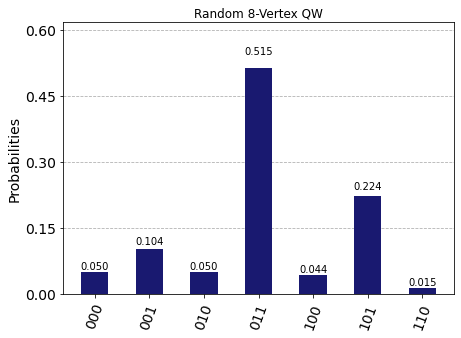

In [ ]:
# execute simulation of random graph QW and plot histogram
job = execute(circ_random, backend=BasicAer.get_backend('qasm_simulator'))
plot_histogram(job.result().get_counts(), color='midnightblue', title="Random 8-Vertex QW")

While the above visualizations verify that our code for quantum walks is working correctly, we want to be able to visualize the overall evolution of the quantum walk on the graph instead of just the end result. In order to do this, we developed functions to evolve the state of the quantum system in small pieces, taking a "snapshot" of the state of the system after each iteration. This way, we will be able to better visualize how the "quantum walker" is moving throughout the graph.

In [ ]:
def create_walk_circuit(adj_matrix, total_dur, num_snaps):
    '''
    Helper function for generating walk circuit with snapshots
    after each evolution of the quantum walk.

    Parameters: adj_matrix (ndarray):   adjacency of graph (2**n, 2**n)
                total_dur (float):      total time for quantum walk
                num_snaps (int):        number of snapshots throughout walk
    Returns:    circ (QuantumCircuit):  resulting circuit
    '''
    # create matrix exponential gate and circuit
    num_qubits = np.log2(len(adj_matrix))
    ExpGate = HamiltonianGate(adj_matrix, total_dur / num_snaps)
    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(num_qubits)
    circ = QuantumCircuit(qr, cr)
    
    # intialize to state |0...01> and add gate with snapshots
    circ.x(0)
    circ.snapshot(str(0))
    for i in range(num_snaps):
        circ.append(ExpGate, qr)
        circ.snapshot(str(i + 1))
    
    # return circuit
    return circ

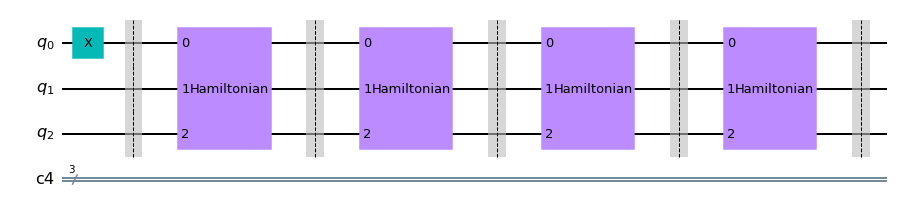

In [ ]:
# visualize simple snapshot circuit for random matrix
random_circuit = create_walk_circuit(random_matrix, 2*np.pi, 4)
random_circuit.draw(output='mpl')

In [ ]:
def get_snapshots(adj_matrix, total_dur, num_snaps):
    '''
    Function for returning snapshots of quantum walk.

    Parameters: adj_matrix (ndarray):   adjacency of graph (2**n, 2**n)
                total_dur (float):      total time for quantum walk
                num_snaps (int):        number of snapshots throughout walk
    Returns:    map from iteration number to snapshot, snapshot counts
                up from binary in ordering (00, 01, 10, 11, ...)
    '''
    qc = create_walk_circuit(adj_matrix, total_dur, num_snaps)
    backend = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend).result()
    return result.data()['snapshots']['statevector']

In [ ]:
# print example of returned map from get_snapshots
print("Map:", get_snapshots(full_mat_P3, 2*np.pi, 8))
print("Starting State:", get_snapshots(full_mat_P3, 2*np.pi, 8)['0'])

Map: {'7': [array([ 0.        +0.j        ,  0.53942727+0.j        ,
        0.        -0.70490494j,  0.        +0.j        ,
       -0.46057273+0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])], '6': [array([ 0.        +0.j        ,  0.96412076+0.j        ,
        0.        -0.26302822j,  0.        +0.j        ,
       -0.03587924+0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])], '8': [array([ 0.        +0.j        ,  0.07089191+0.j        ,
        0.        -0.36294971j,  0.        +0.j        ,
       -0.92910809+0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])], '5': [array([ 0.        +0.j        ,  0.87272667+0.j        ,
        0.        +0.47132756j,  0.        +0.j        ,
       -0.12727333+0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])], '0': [array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0

Now that we have a way to get snapshots from the graph, we can use these snapshots to visualize the evolution of the state of the graph. We first write a function to generate graphs at individual snapshots given the array of the amplitudes of the different qubits.

In [ ]:
def generate_digraph_at_snapshot(adj_matrix, amplitude_array):
    '''
    Helper function that creates a graph for each snapshot.

    Parameters: adj_matrix (ndarray):       adjacency of graph (unpadded, nxn)
                amplitude_array (ndarray):  value from snapshot dictionary for a specific snapshot
    Returns: pydigraph and list of colors for each node in the graph
    '''
    g = retworkx.PyDiGraph()
    n = len(adj_matrix)

    # add nodes
    #lst = ["|" + str(bin(i))[2:].zfill(int(np.log2(n))) + ">" for i in range(n)]
    lst = ["|" + str(bin(2**i))[2:].zfill(int(n)) + ">" for i in range(n)]
    g.add_nodes_from(lst)

    # add edges
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[0])):
            if adj_matrix[i][j] != 0:
                g.add_edge(i, j, adj_matrix[i][j])

    # compute colors based on how probable the node is
    colors = []
    for i in range(len(adj_matrix)):
        alpha = abs(amplitude_array[2 ** i])

        # rescale our transparency
        alpha = alpha * 0.9 + 0.1
        colors.append((0.0, 0.0, 1.0, alpha))
    return g, colors

Using this function, we can animate the quantum walk over the graph and save it as a gif. This particular function assumes the adjacency is unpadded and of dimension $n$x$n$, but could be easily modified to represent graphs with adjacency $2^{n}$x$2^{n}$, where $n$ is the number of qubits.

In [ ]:
def generate_gif(adj_matrix, snapshots, gifname="quantum_walk", snapshot_dir="."):
    '''
    Function that makes a gif of the quantum walk.

    Parameters: adj_matrix (ndarray):       adjacency of graph (unpadded, nxn)
                snapshots (ndarray dict):   map from iteration number to snapshot, snapshot counts
                                            up from binary in ordering (00, 01, 10, 11 for 2 nodes)
                gifname (string):           name of the gif file created
                snapshot_dir (string):      name of the directory to store the snapshot png's
    Returns: saves a gif to the notebook files
    '''
    n = len(snapshots.items())
    pos = None
    # create all the images of the graphs
    for i in range(n):
        g, colors = generate_digraph_at_snapshot(adj_matrix, snapshots[str(i)][0])

        # save the position of the first graph so all subsequent graphs use the same node positioning
        if i == 0:
            pos = retworkx.spring_layout(g)

        plt.clf()
        mpl_draw(g, pos=pos, with_labels=True, labels=lambda node: node, arrows=False, node_size=1000, node_color= colors)
        plt.draw()
        plt.text(0.1, 0.1, 'snapshot ' + str(i), size=15, color='purple')
        plt.savefig(snapshot_dir + '/snapshot' + str(i) + '.png')

    # concatenate images into gif
    images = []
    filenames = [snapshot_dir + '/snapshot' + str(i) + '.png' for i in range(n)]
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(gifname + ".gif", images, duration = .5)

We call the function below for a path on three vertices, showing the final snapshot of the gif.

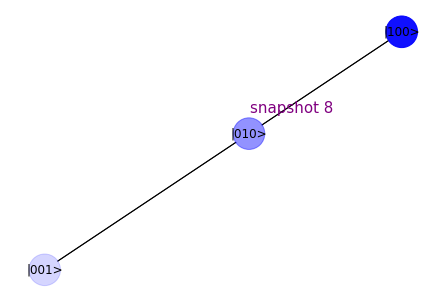

In [ ]:
generate_gif(adj_P3, get_snapshots(full_mat_P3, 2*np.pi, 8))

For user-friendliness, we have combined several of the above functions into one single function. With the adjacency matrix of any graph, this function will pad the matrix to match the dimensionality, get the snapshots, and generate the visualization as a gif.

In [ ]:
def visualize_walk(adj_matrix, total_dur, num_snaps, gifname="quantum_walk", snapshot_dir="."):
    '''
    Function for bringing it all together

    Parameters: adj_matrix (ndarray):   adjacency of graph (unpadded, nxn)
                total_dur (float):      total time for quantum walk
                num_snaps (int):        number of snapshots throughout walk
                gifname (string):       name of the gif file created
                snapshot_dir (string):  name of the directory to store the snapshot png's
    '''
    pad_adj = pad_zeros(adj_matrix)
    snaps = get_snapshots(pad_adj, total_dur, num_snaps)
    generate_gif(adj_matrix, snaps, gifname, snapshot_dir)

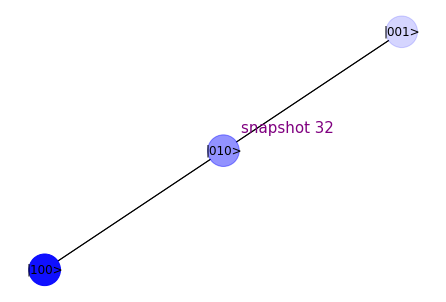

In [ ]:
visualize_walk(adj_P3, 2*np.pi, 32, "P3_quantum_walk", "Snapshots")